<a href="https://colab.research.google.com/github/zobrancova/zuz/blob/master/SlovakBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.9 MB/s eta 0:00:00


In [2]:
import transformers
import torch
from transformers import RobertaTokenizer, RobertaModel, AutoTokenizer, AutoModelForMaskedLM, AutoModel, AutoTokenizer, AutoModelForCausalLM, DebertaTokenizer
from transformers import pipeline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn as nn
import time
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from transformers import RobertaForSequenceClassification, AdamW
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


## Data Import, Preprocessing the data for RELATIONSHIP EXTRACTION

In [3]:
df = pd.read_csv('/content/clean_text_data_for_NER10s.csv')
df['relationship'] = df['relationship'].replace('muź','muž')
df_new = df.dropna()
label_encoder = LabelEncoder()
df_new['relationship_encoded'] = label_encoder.fit_transform(df_new['relationship'])
df_new.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 153
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   URL                   150 non-null    object
 1   Name1                 150 non-null    object
 2   Name2                 150 non-null    object
 3   relationship          150 non-null    object
 4   Clean_Text            150 non-null    object
 5   relationship_encoded  150 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 8.2+ KB


<ipython-input-3-135dd6e5211a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['relationship_encoded'] = label_encoder.fit_transform(df_new['relationship'])


In [4]:
df_copy=df_new.copy()
df_copy['Name1'],df_copy['Name2'] = df_copy['Name2'],df_copy['Name1']
df_copy['relationship'] = df['relationship']

#conditions for changing the relationship
df_copy.loc[df_copy['relationship'] == 'manzel', 'relationship'] = 'manzelka'
df_copy.loc[df_copy['relationship'] == 'manzelka', 'relationship'] = 'manzel'
df_copy.loc[df_copy['relationship'] == 'dieta', 'relationship'] = 'otec'
df_copy.loc[df_copy['relationship'] == 'syn', 'relationship'] = 'otec'
df_copy.loc[df_copy['relationship'] == 'otec', 'relationship'] = 'dieta'
df_copy.loc[df_copy['relationship'] == 'vnuk', 'relationship'] = 'dedko'
df_copy.loc[df_copy['relationship'] == 'trener', 'relationship'] = 'zverenec'
df_copy.loc[df_copy['relationship'] == 'kolegyna', 'relationship'] = 'kolega'
df_copy.loc[df_copy['relationship'] == 'kolega', 'relationship'] = 'kolegyna'
df_copy.loc[df_copy['relationship'] == 'exmanzel', 'relationship'] = 'exmanzelka'
df_copy.loc[df_copy['relationship'] == 'exmanzelka', 'relationship'] = 'exmanzel'
df_copy.loc[df_copy['relationship'] == 'partner', 'relationship'] = 'partnerka'
df_copy.loc[df_copy['relationship'] == 'spoluhráč', 'relationship'] = 'spoluhráč'
df_copy.loc[df_copy['relationship'] == 'snúbenec', 'relationship'] = 'snúbenica'
df_copy.loc[df_copy['relationship'] == 'priateľ', 'relationship'] = 'priateľ'
df_copy.loc[df_copy['relationship'] == 'kamarát', 'relationship'] = 'kamarát'
df_copy.loc[df_copy['relationship'] == 'mama', 'relationship'] = 'dieťa'
df_copy.loc[df_copy['relationship'] == 'neter', 'relationship'] = 'strýko'
df_copy.loc[df_copy['relationship'] == 'strýko', 'relationship'] = 'neter'
df_copy.loc[df_copy['relationship'] == 'vnuk', 'relationship'] = 'starý rodič'
df_copy.loc[df_copy['relationship'] == 'synovec', 'relationship'] = 'ujo'
df_copy.loc[df_copy['relationship'] == 'expriateľka', 'relationship'] = 'expriateľ'
df_copy.loc[df_copy['relationship'] == 'svokra', 'relationship'] = 'zať'
df_large = df_new.append(df_copy, ignore_index=True)
df_large.info()
df_new = df_large
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   URL                   300 non-null    object
 1   Name1                 300 non-null    object
 2   Name2                 300 non-null    object
 3   relationship          300 non-null    object
 4   Clean_Text            300 non-null    object
 5   relationship_encoded  300 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 14.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   URL                   300 non-null    object
 1   Name1                 300 non-null    object
 2   Name2                 300 non-null    object
 3   relationship          300 non-null    object
 4   Clean_Text            300 non-null  

<ipython-input-4-9a0f948644a0>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_large = df_new.append(df_copy, ignore_index=True)


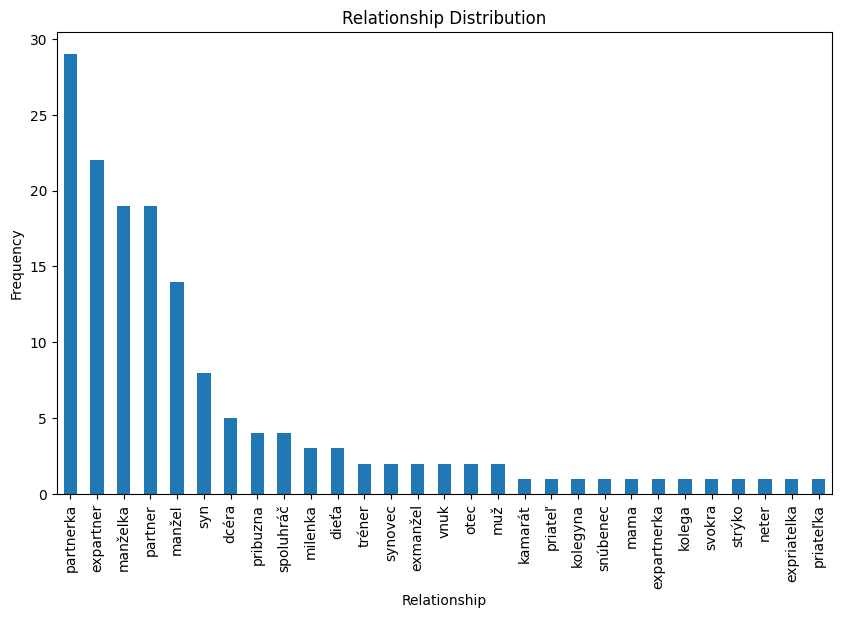

In [5]:
#as we want to teach our model on most frequent classes we will delete those which occure only few times
relationship_distribution = df['relationship'].value_counts()
plt.figure(figsize=(10, 6))
relationship_distribution .plot(kind='bar')
plt.xlabel('Relationship')
plt.ylabel('Frequency')
plt.title('Relationship Distribution')
plt.show()

In [6]:
# relationship_distribution_sorted = relationship_distribution.sort_values(ascending=False)
# relationship_distribution_least = relationship_distribution_sorted.index[-18:].tolist()
# df_new = df_new[~df_new['relationship'].isin(relationship_distribution_least)]
# print(relationship_distribution_sorted)
# print(relationship_distribution_least)

In [7]:
df_new['relationship'].unique()

array(['partnerka', 'dieťa', 'pribuzna', 'syn', 'milenka', 'svokra',
       'synovec', 'expriatelka', 'neter', 'strýko', 'vnuk', 'manželka',
       'expartner', 'manžel', 'partner', 'otec', 'snúbenec', 'kolega',
       'expartnerka', 'mama', 'tréner', 'dcéra', 'spoluhráč', 'kolegyna',
       'muž', 'exmanžel', 'priateľ', 'kamarát', 'priateľka', 'dieta',
       'zať', 'ujo', 'dedko', 'snúbenica'], dtype=object)

In [8]:
df_new['relationship'].unique()

array(['partnerka', 'dieťa', 'pribuzna', 'syn', 'milenka', 'svokra',
       'synovec', 'expriatelka', 'neter', 'strýko', 'vnuk', 'manželka',
       'expartner', 'manžel', 'partner', 'otec', 'snúbenec', 'kolega',
       'expartnerka', 'mama', 'tréner', 'dcéra', 'spoluhráč', 'kolegyna',
       'muž', 'exmanžel', 'priateľ', 'kamarát', 'priateľka', 'dieta',
       'zať', 'ujo', 'dedko', 'snúbenica'], dtype=object)

In [9]:
print(df_new.columns)

Index(['URL', 'Name1', 'Name2', 'relationship', 'Clean_Text',
       'relationship_encoded'],
      dtype='object')


In [10]:
print(len(df_new))

300


In [11]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   URL                   300 non-null    object
 1   Name1                 300 non-null    object
 2   Name2                 300 non-null    object
 3   relationship          300 non-null    object
 4   Clean_Text            300 non-null    object
 5   relationship_encoded  300 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 14.2+ KB


In [12]:
X = df_new[['Name1', 'Name2', 'Clean_Text']]
y = df_new['relationship_encoded']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))
print(X_train['Clean_Text'])
print(len(X_train['Clean_Text']))
print(y_train.head())

240
60
240
60
232    ým Zuzana ako Františkova manželka zo seriálu ...
59     Sú tomu už takmer dva roky, kedy slovenskú ver...
6      ISTANBUL - Boris Kollár aktuálne trávi čas s m...
185    Napriek tomu, že jeho mladučká priateľka, mode...
173    BORA BORA - Tá je ale odvážna! Priateľka Jarom...
                             ...                        
188    Kedysi by ste ho nespoznali - nosil náušnice v...
71     Miroslav Šatan sa včera oženil, svoje ďalšie k...
106    V úplnom závere aktuálnej časti šou 2 na 1 sa ...
270    Jeho rodinka sa rozrastie! Herecká hviezda Bra...
102    Sú páry, ktoré sú spolu roky rokúce a beztak p...
Name: Clean_Text, Length: 240, dtype: object
240
232    25
59     16
6      17
185    17
173    17
Name: relationship_encoded, dtype: int64


## Tokenizing the input data

In [13]:
tokenizer2 = RobertaTokenizer.from_pretrained('gerulata/slovakbert')
inputdata_train2 = tokenizer2(list(X_train['Clean_Text']), padding=True, truncation=True, max_length=512, return_tensors="pt")
inputdata_val2 = tokenizer2(list(X_val['Clean_Text']), padding=True, truncation=True, max_length=512, return_tensors="pt")
y_train_tensor = torch.tensor(y_train.values)
y_val_tensor = torch.tensor(y_val.values)
print("Shape of y_train_tensor:", y_train_tensor.shape)
print("Shape of y_train_tensor:", y_train_tensor.shape)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/533k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

Shape of y_train_tensor: torch.Size([240])
Shape of y_train_tensor: torch.Size([240])


In [14]:
batch_for_train = 8
batch_for_validation = 8

In [15]:
train_data2 = TensorDataset(inputdata_train2["input_ids"], inputdata_train2["attention_mask"], y_train_tensor.clone().detach())
val_data2 = TensorDataset(inputdata_val2["input_ids"], inputdata_val2["attention_mask"], torch.tensor(y_val_tensor))

train_loader2 = DataLoader(train_data2, batch_size=batch_for_train, shuffle=True)
val_loader2 = DataLoader(val_data2, batch_size=batch_for_validation)

<ipython-input-15-713ef8a473c2>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data2 = TensorDataset(inputdata_val2["input_ids"], inputdata_val2["attention_mask"], torch.tensor(y_val_tensor))


## Model Initialization, Fine-tuning the model, validation

In [16]:
model2 = RobertaModel.from_pretrained('gerulata/slovakbert')
num_train_iterations = 10
warm_up_step = len(y_train) * batch_for_train
total_steps = num_train_iterations * warm_up_step
warmup_proportion = 0.1
warm_up = int(total_steps * warmup_proportion)
optimizer2 = AdamW(model2.parameters(), lr=5e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer2, T_0=total_steps, T_mult=2, eta_min=1e-6)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at gerulata/slovakbert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
num_classes = len(df_new['relationship_encoded'].unique())
print("Number of classes:", num_classes)
num_train_iterations = 30

Number of classes: 29


Iteration 1/30, Training Loss: 4.855113704999288


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 1/30, Validation Accuracy: 0.13333333333333333, Validation Precision: 0.017777777777777778, Validation Recall: 0.13333333333333333, Validation F1-score: 0.03137254901960784
Iteration 2/30, Training Loss: 3.9113998730977375


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 2/30, Validation Accuracy: 0.21666666666666667, Validation Precision: 0.060419114766940854, Validation Recall: 0.21666666666666667, Validation F1-score: 0.09424603174603176
Iteration 3/30, Training Loss: 3.676472274462382


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 3/30, Validation Accuracy: 0.26666666666666666, Validation Precision: 0.19785714285714284, Validation Recall: 0.26666666666666666, Validation F1-score: 0.21052631578947364
Iteration 4/30, Training Loss: 3.0589970350265503


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 4/30, Validation Accuracy: 0.43333333333333335, Validation Precision: 0.31141339869281043, Validation Recall: 0.43333333333333335, Validation F1-score: 0.34281794931411297
Iteration 5/30, Training Loss: 2.6045003215471905


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 5/30, Validation Accuracy: 0.4666666666666667, Validation Precision: 0.4742802519118309, Validation Recall: 0.4666666666666667, Validation F1-score: 0.35621212121212126
Iteration 6/30, Training Loss: 2.207180070877075


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 6/30, Validation Accuracy: 0.6, Validation Precision: 0.4390873015873016, Validation Recall: 0.6, Validation F1-score: 0.4948538011695906
Iteration 7/30, Training Loss: 1.8879126171271006


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 7/30, Validation Accuracy: 0.65, Validation Precision: 0.4978379028379028, Validation Recall: 0.65, Validation F1-score: 0.5555863077233313
Iteration 8/30, Training Loss: 1.6541042248408


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 8/30, Validation Accuracy: 0.6833333333333333, Validation Precision: 0.5344283167812579, Validation Recall: 0.6833333333333333, Validation F1-score: 0.5953487886382623
Iteration 9/30, Training Loss: 1.357981654504935


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 9/30, Validation Accuracy: 0.6666666666666666, Validation Precision: 0.5144444444444445, Validation Recall: 0.6666666666666666, Validation F1-score: 0.5741741634324754
Iteration 10/30, Training Loss: 1.2723020533720653


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 10/30, Validation Accuracy: 0.6666666666666666, Validation Precision: 0.6006644880174292, Validation Recall: 0.6666666666666666, Validation F1-score: 0.5988296344178697
Iteration 11/30, Training Loss: 1.0880738814671835


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 11/30, Validation Accuracy: 0.6833333333333333, Validation Precision: 0.6930555555555556, Validation Recall: 0.6833333333333333, Validation F1-score: 0.6422012645637966
Iteration 12/30, Training Loss: 1.0374707544843356


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 12/30, Validation Accuracy: 0.75, Validation Precision: 0.7146545584045584, Validation Recall: 0.75, Validation F1-score: 0.7233380508380508
Iteration 13/30, Training Loss: 0.9353306700785955


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 13/30, Validation Accuracy: 0.65, Validation Precision: 0.6681746031746031, Validation Recall: 0.65, Validation F1-score: 0.6208333333333333
Iteration 14/30, Training Loss: 0.8532603974143664


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 14/30, Validation Accuracy: 0.7166666666666667, Validation Precision: 0.7468518518518519, Validation Recall: 0.7166666666666667, Validation F1-score: 0.7081746031746032
Iteration 15/30, Training Loss: 0.8297921359539032


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 15/30, Validation Accuracy: 0.7333333333333333, Validation Precision: 0.7293981481481481, Validation Recall: 0.7333333333333333, Validation F1-score: 0.7247269397269397
Iteration 16/30, Training Loss: 0.7512579222520193


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 16/30, Validation Accuracy: 0.7333333333333333, Validation Precision: 0.7351190476190477, Validation Recall: 0.7333333333333333, Validation F1-score: 0.6990896358543418
Iteration 17/30, Training Loss: 0.7152802740534147


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 17/30, Validation Accuracy: 0.7166666666666667, Validation Precision: 0.7112037037037038, Validation Recall: 0.7166666666666667, Validation F1-score: 0.7042988710635769
Iteration 18/30, Training Loss: 0.6907729739944141


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 18/30, Validation Accuracy: 0.7, Validation Precision: 0.6939814814814814, Validation Recall: 0.7, Validation F1-score: 0.6868385536032595
Iteration 19/30, Training Loss: 0.6554904888073604


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 19/30, Validation Accuracy: 0.75, Validation Precision: 0.7735449735449735, Validation Recall: 0.75, Validation F1-score: 0.7466737184384243
Iteration 20/30, Training Loss: 0.6754196082552274


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 20/30, Validation Accuracy: 0.6833333333333333, Validation Precision: 0.6877777777777779, Validation Recall: 0.6833333333333333, Validation F1-score: 0.665459192223898
Iteration 21/30, Training Loss: 0.6341750435531139


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 21/30, Validation Accuracy: 0.7333333333333333, Validation Precision: 0.7214865689865689, Validation Recall: 0.7333333333333333, Validation F1-score: 0.7192171717171718
Iteration 22/30, Training Loss: 0.6197000277539094


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 22/30, Validation Accuracy: 0.7333333333333333, Validation Precision: 0.7293981481481481, Validation Recall: 0.7333333333333333, Validation F1-score: 0.7247269397269397
Iteration 23/30, Training Loss: 0.6500184054176013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 23/30, Validation Accuracy: 0.7166666666666667, Validation Precision: 0.7310897435897435, Validation Recall: 0.7166666666666667, Validation F1-score: 0.689922969187675
Iteration 24/30, Training Loss: 0.6363348012169202


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 24/30, Validation Accuracy: 0.7333333333333333, Validation Precision: 0.7756532356532356, Validation Recall: 0.7333333333333333, Validation F1-score: 0.7407190032190033
Iteration 25/30, Training Loss: 0.5870599935452143


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 25/30, Validation Accuracy: 0.7, Validation Precision: 0.7001190476190475, Validation Recall: 0.7, Validation F1-score: 0.6900505050505051
Iteration 26/30, Training Loss: 0.5774158877631028


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 26/30, Validation Accuracy: 0.75, Validation Precision: 0.7663939763939764, Validation Recall: 0.75, Validation F1-score: 0.7396367521367521
Iteration 27/30, Training Loss: 0.5709767629702885


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 27/30, Validation Accuracy: 0.7333333333333333, Validation Precision: 0.7293981481481481, Validation Recall: 0.7333333333333333, Validation F1-score: 0.7247269397269397
Iteration 28/30, Training Loss: 0.5639535581072171


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 28/30, Validation Accuracy: 0.7, Validation Precision: 0.7403490028490028, Validation Recall: 0.7, Validation F1-score: 0.6910052202699262
Iteration 29/30, Training Loss: 0.5569597855210304


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 29/30, Validation Accuracy: 0.7666666666666667, Validation Precision: 0.7569032356532356, Validation Recall: 0.7666666666666667, Validation F1-score: 0.757105557840852
Iteration 30/30, Training Loss: 0.5316297377149264


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Iteration 30/30, Validation Accuracy: 0.7166666666666667, Validation Precision: 0.7403490028490028, Validation Recall: 0.7166666666666667, Validation F1-score: 0.7083129125776184


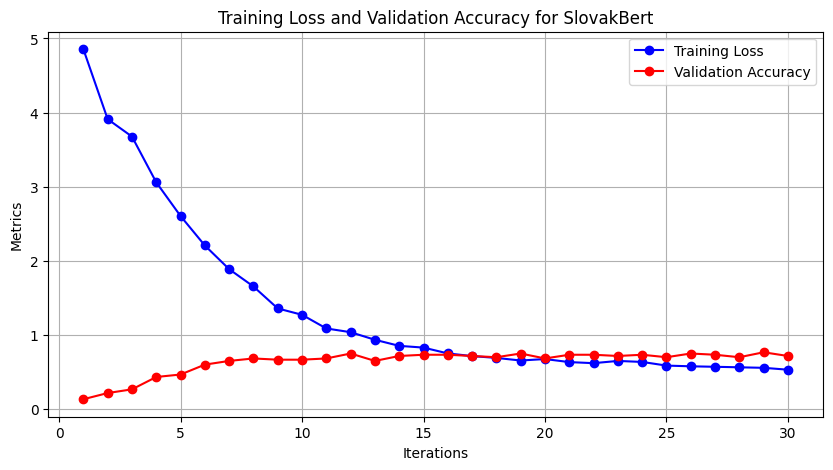

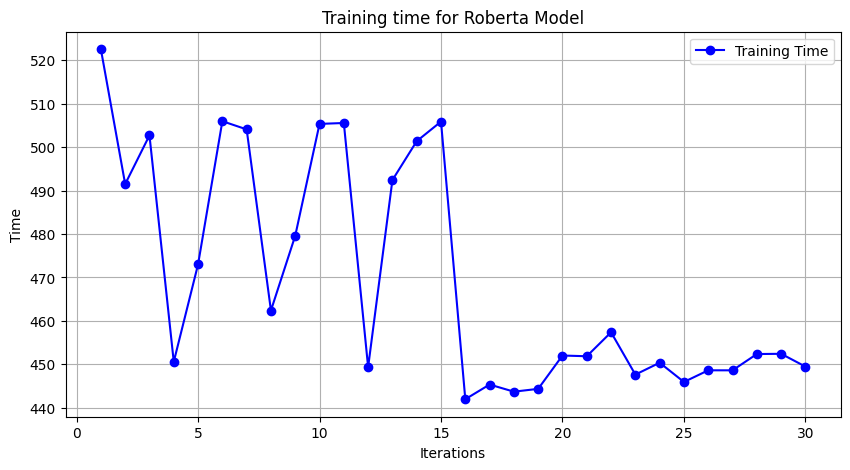

In [18]:
lossfunction = nn.CrossEntropyLoss()
batch_size = train_loader2.batch_size
train_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []
times = []
# fine tuning, I started with few iterations to see if the model is progressing
for i in range(num_train_iterations):
    start = time.time()
    model2.train()
    total_train_loss = 0
    num_train_batches = 0
    total_predictions = []

    for batch in train_loader2:
        input_ids, attention_mask, labels = batch
        optimizer2.zero_grad()
        outputs = model2(input_ids, attention_mask=attention_mask)
        logits = outputs[0]
        labels = labels.view(-1)
        logits = torch.mean(logits, dim=1)

        loss = lossfunction(logits, labels)
        loss.backward()
        optimizer2.step()

        predictions = torch.argmax(logits, dim=1)
        total_predictions.extend(predictions.tolist())

        total_train_loss += loss.item()
        num_train_batches += 1

    #  training loss
    avg_train_loss = total_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    print(f'Iteration {i + 1}/{num_train_iterations}, Training Loss: {avg_train_loss}')
    scheduler.step()
    end = time.time()
    train_time = end - start
    times.append(train_time)
    ## VALIDATION

    model2.eval()
    val_predictions = []
    val_true_labels = []
    total_predictions_val = []
    true_labels_val = []
    with torch.no_grad():
        for batch in val_loader2:
            input_ids, attention_mask, labels = batch
            outputs = model2(input_ids, attention_mask=attention_mask)
            logits = outputs[0]
            logits = torch.mean(logits, dim=1)
            predictions = torch.argmax(logits, dim=1)

            total_predictions_val.extend(predictions.tolist())
            true_labels_val.extend(labels.tolist())
    accuracy_val = accuracy_score(true_labels_val, total_predictions_val)
    precision_val = precision_score(true_labels_val, total_predictions_val, average='weighted')
    recall_val = recall_score(true_labels_val, total_predictions_val, average='weighted')
    f1_val = f1_score(true_labels_val, total_predictions_val, average='weighted')

    val_accuracies.append(accuracy_val)
    val_precisions.append(precision_val)
    val_recalls.append(recall_val)
    val_f1_scores.append(f1_val)
    scheduler.step()

    print(f'Iteration {i + 1}/{num_train_iterations}, Validation Accuracy: {accuracy_val}, Validation Precision: {precision_val}, Validation Recall: {recall_val}, Validation F1-score: {f1_val}')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_train_iterations + 1), train_losses, label='Training Loss', marker='o', color='b')
plt.plot(range(1, num_train_iterations + 1), val_accuracies, label='Validation Accuracy', marker='o', color='r')
plt.title('Training Loss and Validation Accuracy for SlovakBert')
plt.xlabel('Iterations')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()


#training time graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_train_iterations + 1), times, label='Training Time', marker='o', color='b')
plt.title('Training time for Roberta Model')
plt.xlabel('Iterations')
plt.ylabel('Time')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
## save the model to HF
#!pip install huggingface_hub

from huggingface_hub import HfApi

##https://huggingface.co/transformers/v4.0.1/model_sharing.html

model2.save_pretrained("/content/model")


SyntaxError: invalid syntax (<ipython-input-28-9fd4b7151dd5>, line 1)

## Testing

In [19]:
df_test = pd.read_csv('/content/test_data.csv')
X_test = df_new[['Name1', 'Name2', 'Clean_Text']]
y_test = df_new['relationship_encoded']
inputdata_test = tokenizer2(list(X_test['Clean_Text']), padding=True, truncation=True, max_length=512, return_tensors="pt")
y_test_tensor = torch.tensor(y_test.values)
batch = 2
print("Shape of y_test_tensor:", y_test_tensor.shape)
test_data = TensorDataset(inputdata_test["input_ids"], inputdata_val2["attention_mask"], torch.tensor(y_test_tensor))
test_loader = DataLoader(test_data, batch_size=batch, shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: '/content/test_data.csv'